In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
# Load Data
pokemon_df = pd.read_csv("../data/pokemon.csv")
combats_df = pd.read_csv("../data/combats.csv")

# Rename and index for merging
pokemon_df.rename(columns={"#": "ID"}, inplace=True)

In [3]:
# Add Base Stat Total (BST)
pokemon_df["BST"] = pokemon_df[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].sum(axis=1)
pokemon_df = pokemon_df.set_index("ID")
pokemon_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,BST
ID,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,309


In [4]:
# Function to compute type effectiveness using the type chart
def compute_type_effectiveness(attacker_types, defender_types, chart_df):
    effectiveness = 1.0
    for atk_type in attacker_types:
        for def_type in defender_types:
            try:
                multiplier = chart_df.loc[chart_df['Attacking'] == atk_type, def_type].values[0]
                effectiveness *= multiplier
            except (KeyError, IndexError):
                effectiveness *= 1.0  # fallback to neutral
    return effectiveness

In [5]:
# Merge Combat Data with Pokémon Stats including BST
def get_features(row):
    p1 = pokemon_df.loc[row["First_pokemon"]]
    p2 = pokemon_df.loc[row["Second_pokemon"]]
    features = (
        p1[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].tolist() +
        p2[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].tolist() +
        [p1["BST"], p2["BST"]]
    )
    return pd.Series(features)

feature_df = combats_df.apply(get_features, axis=1)
feature_df.columns = [
    "P1_HP", "P1_Atk", "P1_Def", "P1_SpAtk", "P1_SpDef", "P1_Spd",
    "P2_HP", "P2_Atk", "P2_Def", "P2_SpAtk", "P2_SpDef", "P2_Spd",
    "P1_BST", "P2_BST"
]

# Add target label
feature_df["Winner"] = combats_df["Winner"]
feature_df["Label"] = (feature_df["Winner"] == combats_df["First_pokemon"]).astype(int)

feature_df.head()

,P1_HP,P1_Atk,P1_Def,P1_SpAtk,P1_SpDef,P1_Spd,P2_HP,P2_Atk,P2_Def,P2_SpAtk,P2_SpDef,P2_Spd,P1_BST,P2_BST,Winner,Label
0,50,64,50,45,50,41,70,70,40,60,40,60,300,340,298,0
1,91,90,72,90,129,108,91,129,90,72,90,108,580,580,701,0
2,55,40,85,80,105,40,75,75,75,125,95,40,405,485,668,0
3,40,40,40,70,40,20,77,120,90,60,90,48,250,485,683,0
4,70,60,125,115,70,55,20,10,230,10,230,5,495,505,151,1


In [6]:
# Load type chart
type_chart = pd.read_csv("../data/Pokemon Type Chart.csv")

# Compute effectiveness for each battle
def compute_effectiveness_features(row):
    p1 = pokemon_df.loc[row["First_pokemon"]]
    p2 = pokemon_df.loc[row["Second_pokemon"]]

    p1_types = [p1["Type 1"]]
    if pd.notna(p1["Type 2"]):
        p1_types.append(p1["Type 2"])

    p2_types = [p2["Type 1"]]
    if pd.notna(p2["Type 2"]):
        p2_types.append(p2["Type 2"])

    p1_vs_p2_eff = compute_type_effectiveness(p1_types, p2_types, type_chart)
    p2_vs_p1_eff = compute_type_effectiveness(p2_types, p1_types, type_chart)

    return pd.Series([p1_vs_p2_eff, p2_vs_p1_eff])

# Apply to create 2 new columns
feature_df[["P1_vs_P2_TypeEff", "P2_vs_P1_TypeEff"]] = combats_df.apply(compute_effectiveness_features, axis=1)

In [7]:
# Add effectiveness columns to feature_df
feature_df[["P1_vs_P2_TypeEff", "P2_vs_P1_TypeEff"]] = combats_df.apply(compute_effectiveness_features, axis=1)
feature_df.head()

,P1_HP,P1_Atk,P1_Def,P1_SpAtk,P1_SpDef,P1_Spd,P2_HP,P2_Atk,P2_Def,P2_SpAtk,P2_SpDef,P2_Spd,P1_BST,P2_BST,Winner,Label,P1_vs_P2_TypeEff,P2_vs_P1_TypeEff
0,50,64,50,45,50,41,70,70,40,60,40,60,300,340,298,0,1.0,1.0
1,91,90,72,90,129,108,91,129,90,72,90,108,580,580,701,0,1.0,1.0
2,55,40,85,80,105,40,75,75,75,125,95,40,405,485,668,0,1.0,1.0
3,40,40,40,70,40,20,77,120,90,60,90,48,250,485,683,0,1.0,1.0
4,70,60,125,115,70,55,20,10,230,10,230,5,495,505,151,1,1.0,1.0


In [8]:
# Add Differential Features
feature_df["HP_Diff"] = feature_df["P1_HP"] - feature_df["P2_HP"]
feature_df["Atk_Def_Diff"] = feature_df["P1_Atk"] - feature_df["P2_Def"]
feature_df["SpAtk_SpDef_Diff"] = feature_df["P1_SpAtk"] - feature_df["P2_SpDef"]
feature_df["SpDef_SpAtk_Diff"] = feature_df["P1_SpDef"] - feature_df["P2_SpAtk"]
feature_df["Speed_Diff"] = feature_df["P1_Spd"] - feature_df["P2_Spd"]
feature_df["BST_Diff"] = feature_df["P1_BST"] - feature_df["P2_BST"]

In [9]:
# Balance Dataset by Equalizing Win Labels

# Check initial label distribution
print("Original Win Distribution:")
print(feature_df["Label"].value_counts())

# Separate wins for Player 1 and Player 2
p1_wins = feature_df[feature_df["Label"] == 1]
p2_wins = feature_df[feature_df["Label"] == 0]

# Get the smaller class size
min_len = min(len(p1_wins), len(p2_wins))

# Sample equal amounts from both classes
balanced_df = pd.concat([
    p1_wins.sample(min_len, random_state=42),
    p2_wins.sample(min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new distribution
print("Balanced Win Distribution:")
print(balanced_df["Label"].value_counts())


Original Win Distribution:
Label
0    26399
1    23601
Name: count, dtype: int64
Balanced Win Distribution:
Label
1    23601
0    23601
Name: count, dtype: int64


In [10]:
# Add type effectiveness difference feature
feature_df["TypeEff_Diff"] = feature_df["P1_vs_P2_TypeEff"] - feature_df["P2_vs_P1_TypeEff"]


In [11]:
# Preprocessing
X = feature_df[[
    "P1_HP", "P1_Atk", "P1_Def", "P1_SpAtk", "P1_SpDef", "P1_Spd",
    "P2_HP", "P2_Atk", "P2_Def", "P2_SpAtk", "P2_SpDef", "P2_Spd",
    "P1_BST", "P2_BST",
    "TypeEff_Diff"
]]
y = feature_df["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5247
           1       0.89      0.88      0.88      4753

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



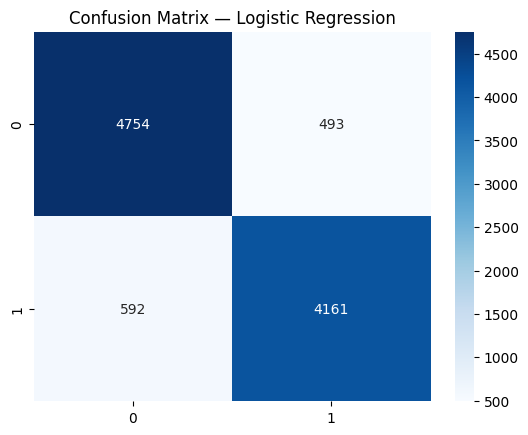

In [12]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

Random Forest Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5247
           1       0.94      0.94      0.94      4753

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



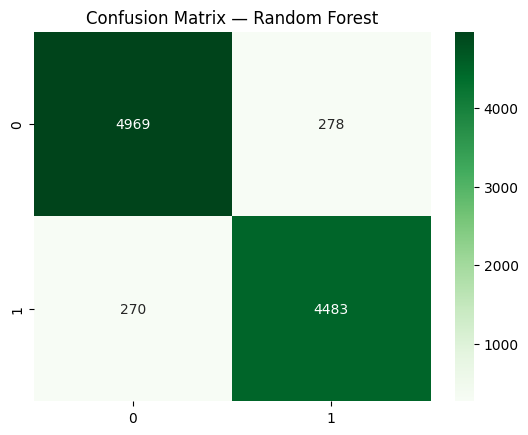

In [13]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.show()

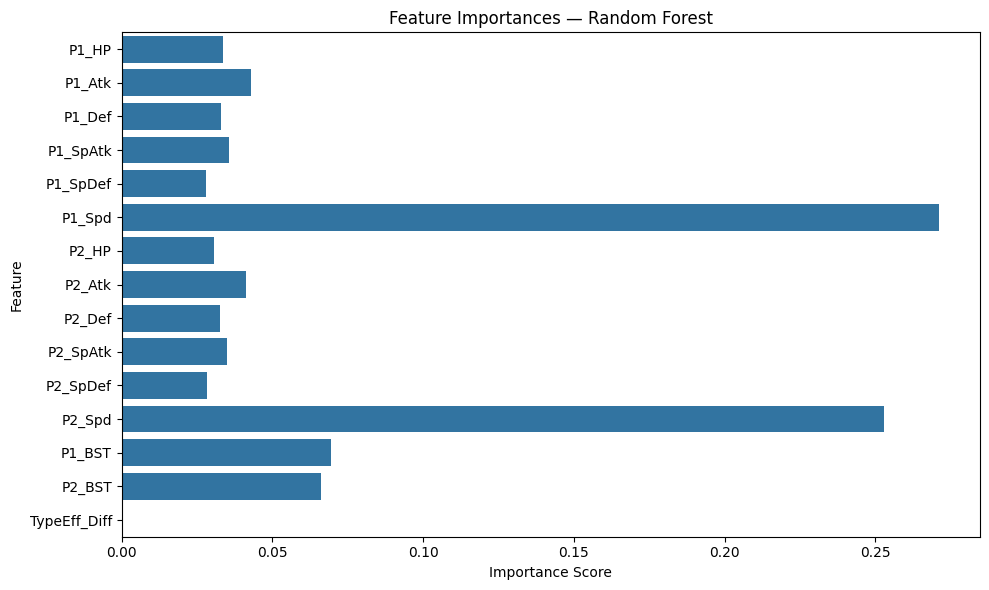

In [14]:
# Feature Importance Check (Random Forest)
import matplotlib.pyplot as plt

feature_names = X.columns
importances = rf.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances — Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Ensemble Model Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5247
           1       0.93      0.93      0.93      4753

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



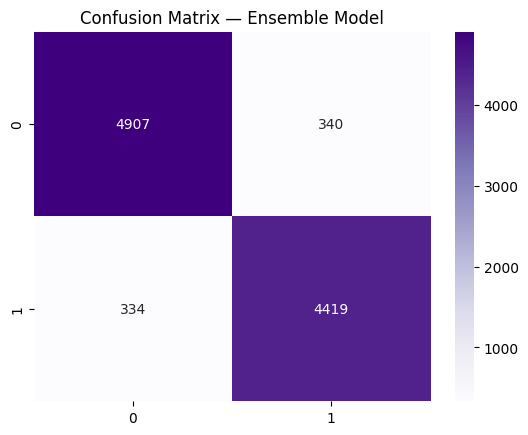

In [15]:
# Ensemble Model (Logistic Regression + Random Forest)
from sklearn.ensemble import VotingClassifier

# Initialize individual models again
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Combine with VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf)
], voting='soft')

# Fit ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

print("Ensemble Model Report:")
print(classification_report(y_test, y_pred_ensemble))
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble), annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix — Ensemble Model")
plt.show()


In [16]:
# Save the ensemble model and scaler
joblib.dump(ensemble_model, "../models/model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("Ensemble model and scaler saved.")

Ensemble model and scaler saved.


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss

# Prepare a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Log Loss": loss
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)


C:\Users\samue\Downloads\TXST items\Spring 2025\Intro to Machine Learning - 4347\CS4347 Project\Pokemon-Battle-Predictor\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [13:39:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  F1 Score  Log Loss
4              XGBoost    0.9478  0.945306  0.157681
1        Random Forest    0.9446  0.941770  0.223584
3                  SVM    0.9239  0.920004  0.275685
0  Logistic Regression    0.8915  0.884660  0.365317
2  K-Nearest Neighbors    0.8763  0.869666  1.018743
